# Here you need to add the paper title, and then a small block of general explanation for a binder

# Experiments on neuromuscular efficiency of respiratory muscles

Import libraries

In [40]:
import copy
import math
import collections
from scipy import interpolate as interp
import scipy
import pandas as pd
import glob
import os
import sys
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from datetime import datetime
%matplotlib widget

# The cell below will need to be changed for a generalized binder

In [4]:
sys.path.insert(0, '../ReSurfEMG')
import helper_functions as hf
from config import Config
config = Config()

In [5]:
# get new changes in our library i.e. the tmsisdk
import sys
sys.path.insert(0, '../resurfemg')

from tmsisdk_lite import Poly5Reader

# Initiation of output folder for experiments

In [6]:
# Output data - General path to dir for saving .csvs and plots
main_output_dir = config.get_directory('preprocessed') + '/2023_04_SNR_good'
if not os.path.exists(main_output_dir):
    os.makedirs(main_output_dir)

The below cell allows you to pick whether to display and interact with the data in seconds or samples.

In [7]:
y_axis = widgets.Dropdown(
    options=["Samples", "Seconds"],
    value='Seconds',
    description="Select View Option",
    disabled=False,
)
display(y_axis)

Dropdown(description='Select View Option', index=1, options=('Samples', 'Seconds'), value='Seconds')

The below cell confirms your choice.

In [8]:
time_view = y_axis.value
time_view

'Seconds'

<a id='#patient_select'>Input patient file path</a>

In [9]:
# Root directory for patient data
root_patient_data_directory = config.get_directory('root_patient_data_directory')

patient_idx = 0

# Patient data selection

In [10]:
# Reruns should be done from this cell as the start

<a id='section_patient_step'>Next patient</a>

In [11]:
patient_folders = glob.glob(root_patient_data_directory + '/**/', recursive=False)
patients = []

for folder in patient_folders:
    name = folder.split("\\")[-2]
    patients.append(name)

btn_pt = widgets.Dropdown(
    options=patients,
    value=patients[patient_idx],
    description='Select patient:',
    disabled=False,
)

date_idx = 0

display(btn_pt)

Dropdown(description='Select patient:', options=('2022_09-16-Test_lung_data_respiratory_rate_22', 'MST001', 'M…

<a id='section_date_step'>Next date</a>

In [12]:
patient = btn_pt.value
patient_idx =btn_pt.index

measurement_folders = glob.glob(root_patient_data_directory + '/' + patient + '/**/', recursive=False)
measurements = []

for folder in measurement_folders:
    name = folder.split("\\")[-2]
    measurements.append(name)

btn_measurement = widgets.Dropdown(
    options=measurements,
    value=measurements[date_idx],
    description='Select measurement date:',
    disabled=False,
)
display(btn_measurement)

Dropdown(description='Select measurement date:', options=('2021-12-24_09-29-46', '2021-12-27_09-16-26', '2021-…

In [13]:
gate_width = 0.1
gate_twice = False

if not os.path.exists(main_output_dir + '/' + patient + '/' + measurements[date_idx-1]  + '/' + measurements[date_idx-1] + '_' + patient +
          '_NME_output_gate_'+str(int(gate_width*1000))+'.csv'):
    print('Warning: Data not stored! Do not progress to next date!')
    print(measurements[date_idx-1])
else:
    print('Notification: Data stored appropriately! You can progress to next date!')
    print(measurements[date_idx-1])


Notification: Data stored appropriately! You can progress to next date!
2022-01-03_13-11-09


In [14]:
# Rerun for each new measurement DAY (empty output parameter list)!
measurement = btn_measurement.value
date_idx = btn_measurement.index

# Input data
windows_str = root_patient_data_directory + '/' + patient + '/' + measurement
root_emg_directory = os.path.join(windows_str)

# do not rerun this cell
big_data_list = []
ecg_data_list = []


measurement_idx = -4

<a id='section_peep_step'>Next PEEP step</a>

Now you can pick a file from the list, which have been numbered.

In [15]:
# Select measurement number
emg_pattern = os.path.join(root_emg_directory, '**/*.Poly5')
emg_and_draeger_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
draeger_files = []

for file in emg_and_draeger_files:
    if 'Draeger' in file:
        draeger_files.append(file)
    else:
        emg_files.append(file)
list_of_numbers_strung = []

for i in range(len(emg_files)):
    # list_of_numbers_strung.append(str(i))

    list_of_numbers_strung.append(emg_files[i].split('\\')[-2])


btn = widgets.Dropdown(
    options=list_of_numbers_strung,
    value=str(emg_files[measurement_idx].split('\\')[-2]),
    description='Picked File:',
    disabled=False,
)
display(btn)

Dropdown(description='Picked File:', index=5, options=('001', '002', '003', '004', '005', '006', '007', '008',…

In [16]:
number_chosen = int(btn.index)
measurement_idx = int(btn.index)
emg_file_chosen = emg_files[number_chosen]
draeger_file_chosen = draeger_files[number_chosen]
print("The files you chose are:\n", emg_file_chosen, '\n', draeger_file_chosen)

The files you chose are:
 P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW/MST001/2021-12-24_09-29-46\006\EMG_recording.Poly5 
 P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW/MST001/2021-12-24_09-29-46\006\Draeger_recording.Poly5


In [17]:
# get the poly5 reading
data_emg = Poly5Reader(emg_file_chosen)
data_draeger = Poly5Reader(draeger_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
emg_sample_rate = data_emg.sample_rate
data_draeger_samples = data_draeger.samples[:data_draeger.num_samples]
draeger_sample_rate = data_draeger.sample_rate

# Output data path - Patient specific
patient = emg_files[number_chosen].split('\\')[-3].split('/')[-2]
measurement = emg_files[number_chosen].split('\\')[-2]

if not os.path.exists(main_output_dir + '/' + patient + '/'):
    os.makedirs(main_output_dir + '/' + patient + '/')

if not os.path.exists(main_output_dir + '/' + patient + '/' + measurements[date_idx] + '/'):
    os.makedirs(main_output_dir + '/' + patient + '/' + measurements[date_idx] + '/')

Reading file  P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW/MST001/2021-12-24_09-29-46\006\EMG_recording.Poly5
	 Number of samples:  762496 
	 Number of channels:  3 
	 Sample rate: 2048 Hz
Done reading data.
Reading file  P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW/MST001/2021-12-24_09-29-46\006\Draeger_recording.Poly5
	 Number of samples:  37231 
	 Number of channels:  3 
	 Sample rate: 100 Hz
Done reading data.


In [18]:
x_emg = data_emg_samples
x_draeger = data_draeger_samples

y_emg = [i/emg_sample_rate for i in range(len(x_emg[0, :]))]
y_draeger = [i/draeger_sample_rate for i in range(len(x_draeger[0, :]))]

In [19]:
# Load settings from prior run
readme_file_name_prev = config.get_directory('preprocessed') + '/2023_04_SNR_good/' + patient + '/' + measurements[date_idx] + '/' + measurements[date_idx] + '_' + patient + '_' + measurement + '_readme.txt'

if not os.path.exists(readme_file_name_prev):
    readme_file_name_prev = config.get_directory('preprocessed') + '/2023_04_SNR_wrong_ETP_para_baseline/' + patient + '/' + measurements[date_idx] + '/' + measurements[date_idx] + '_' + patient + '_' + measurement + '_readme.txt'

try:
    with open(readme_file_name_prev, 'r') as f:
        readme_str = f.read()
        
        settings_lines = readme_str.split('\n')
        
        
        t_start_prev = float(settings_lines[1].split(' ')[-2])
        t_end_prev = float(settings_lines[2].split(' ')[-2])

        gate_width_prev = float(settings_lines[3].split(' ')[-2])/1000
        gate_threshold_prev = float(settings_lines[4].split(' ')[-1])
        gate_ECG_shift_prev = int(settings_lines[5].split(' ')[-2])
        
        time_shift_prev = float(settings_lines[6].split(' ')[-2])

        Pocc_prominence_factor_prev = float(settings_lines[7].split(' ')[-1])
        EMG_di_prominence_factor_prev = float(settings_lines[8].split(' ')[-1])
        EMG_para_prominence_factor_prev = float(settings_lines[9].split(' ')[-1])

        if len(settings_lines) > 12:
            N_gated = int(settings_lines[11].split(' ')[-1])
            if N_gated == 2:
                gate_twice = True
            

        print(readme_str + '\n')
    f.close()
    prev_settings_loaded = True
except FileNotFoundError:
    print("Log file not found:")
    print(readme_file_name_prev)
    prev_settings_loaded = False
except ValueError:
    print("Error while reading log file!")
    prev_settings_loaded = False

if not prev_settings_loaded:
    t_start_prev = y_draeger[-1]-100
    t_end_prev = y_draeger[-1]-10

    gate_width_prev = 0.10
    gate_threshold_prev = 0.30
    gate_ECG_shift_prev = -10

    time_shift_prev = 0.5                   #Draeger delay
    Pocc_prominence_factor_prev = 0.8
    EMG_di_prominence_factor_prev = 0.01
    EMG_para_prominence_factor_prev = 0.01


MST001 / 2021-12-24_09-29-46 / 006
t_start: 320.0 s
t_end: 365.0 s
gate_width: 100 ms
gate_threshold: 0.3
gate_ECG_shift: -10 samples
time_shift: 0.5 s
Pocc_prominence_factor: 0.5
EMG_di_prominence_factor: 0.01
EMG_para_prominence_factor: 0.01
PEEP_set: 3.0
N_gated: 1
analysis_date: 2023-04-26 10:44:08.330925



In [20]:
# If necessary: Plot data
if not prev_settings_loaded:
    fig, axis = plt.subplots(nrows=3, ncols=4, figsize=(10, 6))
    axis[0, 0].grid(True)
    axis[0, 0].plot(x_emg[0])
    axis[0, 0].set(title='EMG leads: samples')
    axis[1, 0].plot(x_emg[1])
    axis[2, 0].plot(x_emg[2])

    axis[0, 1].set(title='Draeger: samples')
    axis[0, 1].grid(True)
    axis[0, 1].plot(x_draeger[0])
    axis[1, 1].plot(x_draeger[1])
    axis[2, 1].plot(x_draeger[2])

    axis[0, 2].grid(True)
    axis[0, 2].plot(y_emg, x_emg[0])
    axis[0, 2].set(title='EMG leads: seconds')
    axis[1, 2].plot(y_emg, x_emg[1])
    axis[2, 2].plot(y_emg, x_emg[2])

    axis[0, 3].set(title='Draeger :seconds')
    axis[0, 3].grid(True)
    axis[0, 3].plot(y_draeger, x_draeger[0])
    axis[1, 3].plot(y_draeger, x_draeger[1])
    axis[2, 3].plot(y_draeger, x_draeger[2])

Here pick the part of the signal you want to look at. It is advised to never start at zero, or end after the signal, and the widgets have been constrained to do this.

In [21]:
start_widget = widgets.BoundedFloatText(
    value=np.floor(t_start_prev),
    min=1,
    max=y_draeger[-1],
    step=1,
    description='Start:',
    disabled=False
)
end_widget = widgets.BoundedFloatText(
    value=np.floor(t_end_prev),
    min=1,
    max=y_draeger[-1],
    step=1,
    description='End:',
    disabled=False
)
widgets.VBox([start_widget, end_widget])



In [22]:
start = start_widget.value  
end = end_widget.value  
if start >= end:    
    print('Please choose logical values. You made a mistake.')

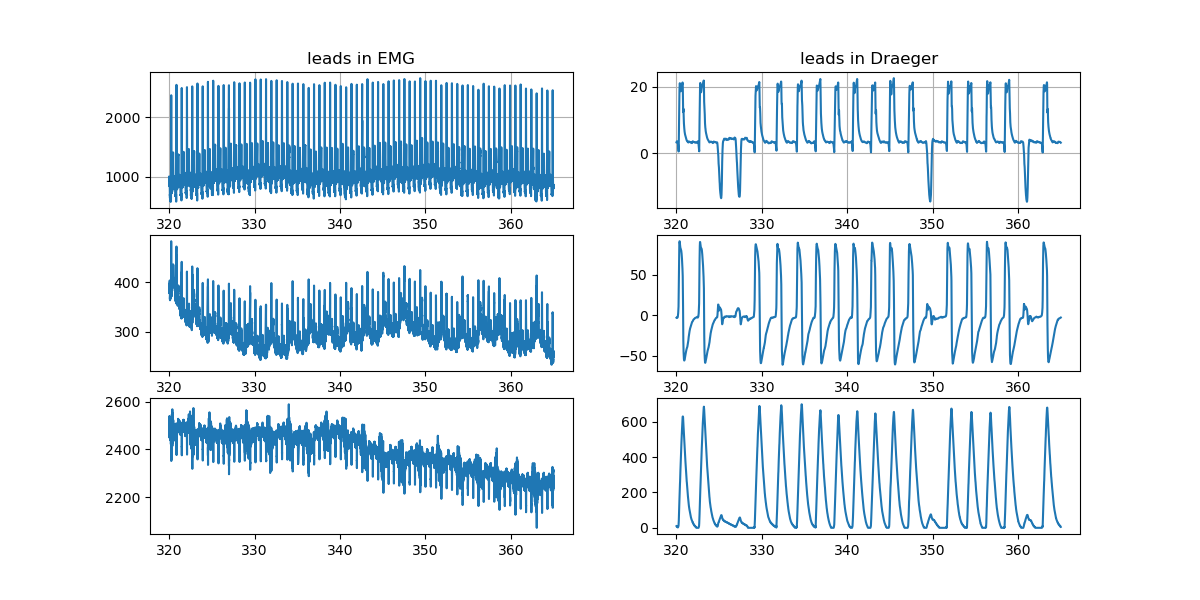

In [23]:
# now examine at the selected window to contain all occlusions

if time_view == 'Seconds':
    start_s = int(float(start)* emg_sample_rate)
    end_s = min([int(float(end)*emg_sample_rate), len(x_emg[0,:])-1])
    start_draeger_s = int(float(start)* draeger_sample_rate)
    end_draeger_s = min([int(float(end)* draeger_sample_rate), len(x_draeger[0,:])-1])

else:
    start_s = int(float(start))
    end_s = min([int(float(end)), len(data_emg_samples[0])-1])
    start_draeger_s = int(float(start)* draeger_sample_rate/emg_sample_rate)
    end_draeger_s = min([int(float(start)* draeger_sample_rate/emg_sample_rate), len(data_draeger_samples[0])-1])
    y_emg = [range(len(data_emg_samples[0]))]
    y_draeger = [range(len(data_draeger_samples[0]))]


fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(12, 6))
axis[0, 0].set(title='leads in EMG')
axis[0, 0].grid(True)
axis[0, 0].plot(y_emg[int(start_s):int(end_s)], x_emg[0][int(start_s):int(end_s)])
axis[1, 0].plot(y_emg[int(start_s):int(end_s)], x_emg[1][int(start_s):int(end_s)])
axis[2, 0].plot(y_emg[int(start_s):int(end_s)], x_emg[2][int(start_s):int(end_s)])

axis[0, 1].set(title='leads in Draeger')
axis[0, 1].grid(True)
axis[0, 1].plot(
    y_draeger[int(start_draeger_s):int(end_draeger_s)], 
    x_draeger[0][int(start_draeger_s):int(end_draeger_s)]
)
axis[1, 1].plot(
    y_draeger[int(start_draeger_s):int(end_draeger_s)], 
    x_draeger[1][int(start_draeger_s):int(end_draeger_s)]
)
axis[2, 1].plot(
    y_draeger[int(start_draeger_s):int(end_draeger_s)], 
    x_draeger[2][int(start_draeger_s):int(end_draeger_s)]
)

# Pre-processing

In [24]:
# Eliminate the baseline wander from the data
bd_filtered_file_data = hf.emg_bandpass_butter_sample(data_emg_samples, 1, 500, 2048, output='sos')
    
processed_data_emg_di = bd_filtered_file_data[1]
processed_data_emg_para = bd_filtered_file_data[2]

In [25]:
# Gating settings
plot_window = 5         # Window size to plot the gating results from

# peak_fraction = 0.30    # Peak height fraction
peak_fraction = gate_threshold_prev     # Peak height fraction

# ECG_shift = -10           # Shift of gated in samples relative to detected peaks
ECG_shift = gate_ECG_shift_prev         # Shift of gated in samples relative to detected peaks

# gate_width = 0.1        # Gate width in seconds
gate_width = gate_width_prev            # Gate width in seconds


# QRS peak detection settings
peak_width = 0.001
peak_dist = int(emg_sample_rate/3)


In [26]:
# Check number of gating iterations
if gate_twice == True:
    print('Signal will be gated TWICE!')
else:
    print('Signal will be gated ONCE!')

Signal will be gated ONCE!


In [27]:
# Apply QRS gating

# Detect ECG peaks on 1Hz high-pass filtered signals
ecg = bd_filtered_file_data[0]
ecg_rms = hf.full_rolling_rms(ecg, 10)
max_ecg_rms = max(ecg_rms[int(start_s):int(start_s+plot_window*emg_sample_rate)])
min_ecg_rms = min(ecg_rms[int(start_s):int(start_s+plot_window*emg_sample_rate)])
peak_height = peak_fraction*(max_ecg_rms - min_ecg_rms)

ECG_peaks, properties  = scipy.signal.find_peaks(
    ecg_rms, 
    height=peak_height, 
    width=peak_width*emg_sample_rate, 
    distance=peak_dist
)
ECG_peaks = ECG_peaks - ECG_shift

# Filter EXG signals 20Hz high pass
ECG_h20 = hf.emg_bandpass_butter_sample(ecg, 20, 500, 2048, output='sos')
emg_di_h20 = hf.emg_bandpass_butter_sample(processed_data_emg_di, 20, 500, 2048, output='sos')
emg_para_h20 = hf.emg_bandpass_butter_sample(processed_data_emg_para, 20, 500, 2048, output='sos')

# Gate ECG and EMG signal
gate_fill_method = 3    # 0: Zeros, 1: Interpolate start-end, 2: Average prior data, 3: Moving average
gate_width_samples = int(gate_width*emg_sample_rate)

gate_samples = list()
for i in range(len(ECG_peaks)):
    for k in range(int(ECG_peaks[i]-gate_width_samples/2),int(ECG_peaks[i]+gate_width_samples/2)):
        gate_samples.append(k)

ECG_gated = hf.gating(ECG_h20, ECG_peaks, gate_width=gate_width_samples, method=3)
emg_di_gated = hf.gating(emg_di_h20, ECG_peaks, gate_width=gate_width_samples, method=3)
emg_para_gated = hf.gating(emg_para_h20, ECG_peaks, gate_width=gate_width_samples, method=3)


In [32]:
# Apply gating twice (in case of pacing)
if gate_twice == True:
    # Detect ECG peaks on 1Hz high-pass filtered signals
    ecg = ECG_gated
    ecg_rms = hf.full_rolling_rms(ecg, 10)
    max_ecg_rms = max(ecg_rms[int(start_s):int(start_s+plot_window*emg_sample_rate)])
    min_ecg_rms = min(ecg_rms[int(start_s):int(start_s+plot_window*emg_sample_rate)])
    peak_height = peak_fraction*(max_ecg_rms - min_ecg_rms)

    ECG_peaks, properties  = scipy.signal.find_peaks(
        ecg_rms, 
        height=peak_height, 
        width=peak_width*emg_sample_rate, 
        distance=peak_dist
    )
    ECG_peaks = ECG_peaks - ECG_shift

    # # Filter EXG signals 20Hz high pass
    # ECG_h20 = hf.emg_bandpass_butter_sample(ECG_gated, 20, 500, 2048, output='sos')
    # emg_di_h20 = hf.emg_bandpass_butter_sample(emg_di_gated, 20, 500, 2048, output='sos')
    # emg_para_h20 = hf.emg_bandpass_butter_sample(emg_para_gated, 20, 500, 2048, output='sos')

    # Gate ECG and EMG signal
    gate_fill_method = 3    # 0: Zeros, 1: Interpolate start-end, 2: Average prior data, 3: Moving average
    gate_width_samples = int(gate_width*emg_sample_rate)

    gate_samples = list()
    for i in range(len(ECG_peaks)):
        for k in range(int(ECG_peaks[i]-gate_width_samples/2),int(ECG_peaks[i]+gate_width_samples/2)):
            gate_samples.append(k)

    ECG_gated = hf.gating(ECG_gated, ECG_peaks, gate_width=gate_width_samples, method=3)
    emg_di_gated = hf.gating(emg_di_gated, ECG_peaks, gate_width=gate_width_samples, method=3)
    emg_para_gated = hf.gating(emg_para_gated, ECG_peaks, gate_width=gate_width_samples, method=3)


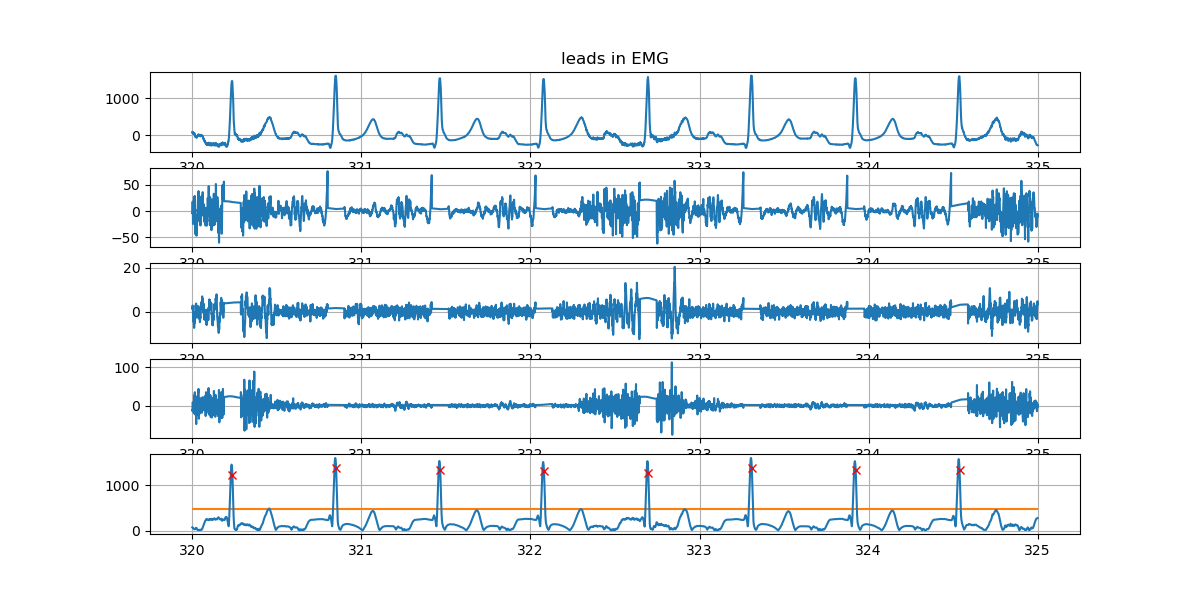

In [34]:
# Plot gating result

fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(12, 6))
start_i = int(start_s)
end_i = int(start_s+plot_window*2048)
axis[0].grid(True)
axis[0].plot(y_emg[start_i:end_i], bd_filtered_file_data[0, start_i:end_i])

axis[0].set(title='leads in EMG')
axis[1].grid(True)
axis[1].plot(y_emg[start_i:end_i], ECG_gated[start_i:end_i])
axis[2].grid(True)
axis[2].plot(y_emg[start_i:end_i], emg_di_gated[start_i:end_i])
axis[3].grid(True)
axis[3].plot(y_emg[start_i:end_i], emg_para_gated[start_i:end_i])

axis[4].grid(True)
axis[4].plot(y_emg[start_i:end_i], ecg_rms[start_i:end_i])
axis[4].hlines(
    y=peak_height, 
    xmin=y_emg[start_i], 
    xmax=y_emg[end_i],
    color = "C1"
)

for idx in range(len(ECG_peaks)):
    if (ECG_peaks[idx] > int(start_s)) & (ECG_peaks[idx] < int(start_s+plot_window*2048)):
        axis[4].plot(y_emg[ECG_peaks[idx]], ecg_rms[ECG_peaks[idx]],'rx')


Calculate root mean squared (RMS)

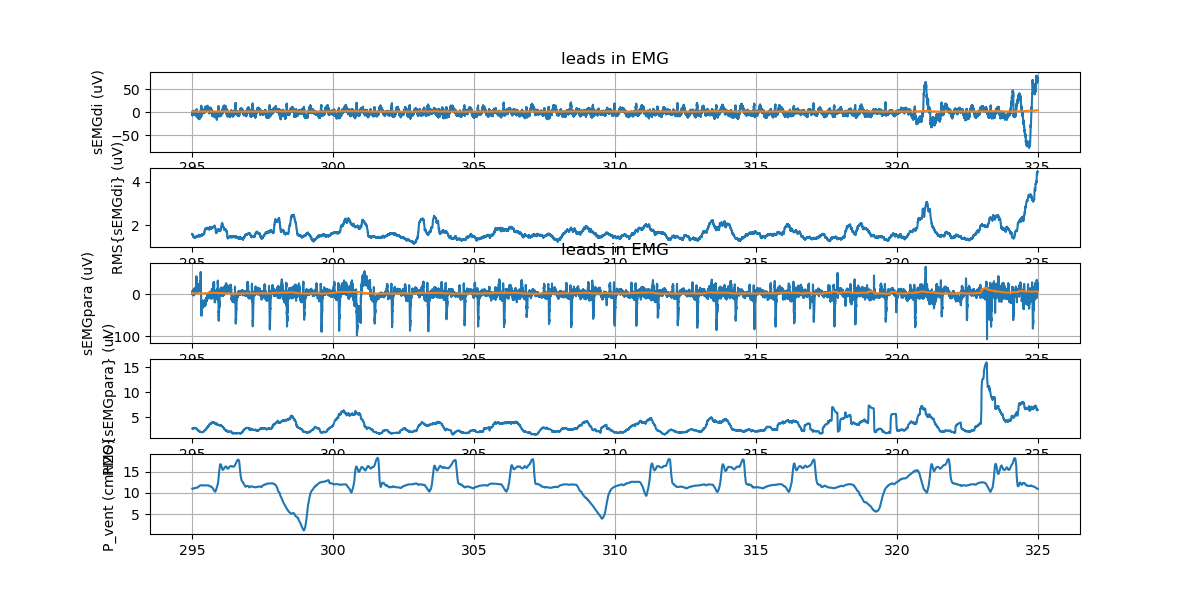

In [2476]:
RMS_window_ms = 200
RMS_windows_samp = int(RMS_window_ms / 1000 *  emg_sample_rate)

RMS_data_emg_di = hf.full_rolling_rms(emg_di_gated, RMS_windows_samp)
RMS_data_emg_para = hf.full_rolling_rms(emg_para_gated, RMS_windows_samp)

fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(12, 6))
axis[0].set(title='leads in EMG')
axis[0].set_ylabel('sEMGdi (uV)')
axis[0].grid(True)
axis[0].plot(y_emg[int(start_s):int(end_s)], processed_data_emg_di[int(start_s):int(end_s)])
axis[0].plot(y_emg[int(start_s):int(end_s)], RMS_data_emg_di[int(start_s):int(end_s)])

axis[1].set_xlabel('t (s)')
axis[1].set_ylabel('RMS{sEMGdi} (uV)')
axis[1].plot(y_emg[int(start_s):int(end_s)], RMS_data_emg_di[int(start_s):int(end_s)])

axis[2].set(title='leads in EMG')
axis[2].set_ylabel('sEMGpara (uV)')
axis[2].grid(True)
axis[2].plot(y_emg[int(start_s):int(end_s)], processed_data_emg_para[int(start_s):int(end_s)])
axis[2].plot(y_emg[int(start_s):int(end_s)], RMS_data_emg_para[int(start_s):int(end_s)])

axis[3].set_xlabel('t (s)')
axis[3].set_ylabel('RMS{sEMGpara} (uV)')
axis[3].plot(y_emg[int(start_s):int(end_s)], RMS_data_emg_para[int(start_s):int(end_s)])

axis[4].set_ylabel('P_vent (cmH2O)')
axis[4].grid(True)
axis[4].plot(
    y_draeger[int(start_draeger_s):int(end_draeger_s)], 
    x_draeger[0][int(start_draeger_s):int(end_draeger_s)]
)



# Feature extraction

Determine PEEP level

In [34]:
x = x_draeger[2][:int(start_draeger_s)]
V_ee_PKS, _ = scipy.signal.find_peaks(-x)

PEEP_set = np.floor(np.median(x_draeger[0, V_ee_PKS]))


PEEP_set

3.0

In [55]:
# Extract ECG-amplitude (RMS)
ecg_data_list_new = (np.column_stack((np.matlib.repmat([patient, measurement, PEEP_set], len(ECG_peaks), 1), ecg_rms[ECG_peaks + ECG_shift])))


In [2478]:
# # Moving baseline SLOW on pressure and all EMG signals for baseline crossing detection

# baseline_W_emg = 5 * emg_sample_rate  # window length
# baseline_W_draeger = 5 * draeger_sample_rate  # window length

# # emg_di_rolling_base_line = np.percentile(strided_app(RMS_data_emg[int(start_s):int(end_s)], W,1), 33, axis=-1)
# emg_di_rolling_base_line = np.zeros(
#     (len(RMS_data_emg_di[int(start_s):int(end_s)]), ))
# emg_para_rolling_base_line = np.zeros(
#     (len(RMS_data_emg_para[int(start_s):int(end_s)]), ))
# P_rolling_base_line = np.zeros(
#     (len(x_draeger[0, int(start_draeger_s):int(end_draeger_s)]), ))

# for idx in range(int(end_s)-int(start_s)):
#     start_i = max([int(start_s), int(start_s)+idx-int(baseline_W_emg/2)])
#     end_i = min([int(end_s), int(start_s)+idx+int(baseline_W_emg/2)])
#     emg_di_rolling_base_line[idx] = np.percentile(
#         RMS_data_emg_di[start_i:end_i], 33)
#     emg_para_rolling_base_line[idx] = np.percentile(
#         RMS_data_emg_para[start_i:end_i], 33)

# for idx in range(int(end_draeger_s)-int(start_draeger_s)):
#     start_i = max([int(start_draeger_s), int(
#         start_draeger_s)+idx-int(baseline_W_draeger/2)])
#     end_i = min([int(end_draeger_s), int(start_draeger_s) +
#                 idx+int(baseline_W_draeger/2)])
#     P_rolling_base_line[idx] = np.percentile(x_draeger[0, start_i:end_i], 33)

In [2479]:
# Moving baseline QUICKer on pressure and all EMG signals for baseline crossing detection

baseline_W_emg = 5 * emg_sample_rate  # window length
baseline_W_draeger = 5 * draeger_sample_rate  # window length

# emg_di_rolling_base_line = np.percentile(strided_app(RMS_data_emg[int(start_s):int(end_s)], W,1), 33, axis=-1)
emg_di_rolling_base_line = np.zeros(
    (len(RMS_data_emg_di[int(start_s):int(end_s)]), ))
emg_para_rolling_base_line = np.zeros(
    (len(RMS_data_emg_para[int(start_s):int(end_s)]), ))
P_rolling_base_line = np.zeros(
    (len(x_draeger[0, int(start_draeger_s):int(end_draeger_s)]), ))

for idx in range(0, int(end_s)-int(start_s), int(emg_sample_rate/5)):
    start_i = max([int(start_s), int(start_s)+idx-int(baseline_W_emg/2)])
    end_i = min([int(end_s), int(start_s)+idx+int(baseline_W_emg/2)])
    baseline_value_emg_di = np.percentile(
        RMS_data_emg_di[start_i:end_i], 33)
    baseline_value_emg_para = np.percentile(
        RMS_data_emg_para[start_i:end_i], 33)
    for i in range(idx, min([idx+int(emg_sample_rate/5), int(end_s)-int(start_s)])):
        emg_di_rolling_base_line[i] = baseline_value_emg_di
        emg_para_rolling_base_line[i] = baseline_value_emg_para

for idx in range(0, int(end_draeger_s)-int(start_draeger_s), int(draeger_sample_rate/5)):
    start_i = max([int(start_draeger_s), int(
        start_draeger_s)+idx-int(baseline_W_draeger/2)])
    end_i = min([int(end_draeger_s), int(start_draeger_s) +
                idx+int(baseline_W_draeger/2)])
    P_rolling_base_line[idx] = np.percentile(x_draeger[0, start_i:end_i], 33)

    baseline_value_P = np.percentile(x_draeger[0, start_i:end_i], 33)
    for i in range(idx, min([idx+int(draeger_sample_rate/5), int(end_s)-int(start_s)])):
        P_rolling_base_line[i] = baseline_value_P

Get PTPocc

In [2480]:
# Pocc_prominence_factor = 0.4
Pocc_prominence_factor = Pocc_prominence_factor_prev


In [2481]:
# Detect (negative) occlussion peaks in pressure signal

treshold = 0
width = int(0.1 * draeger_sample_rate)
prominence = Pocc_prominence_factor *np.abs( PEEP_set - min(x_draeger[0]))
height = -(PEEP_set - Pocc_prominence_factor *np.abs( PEEP_set - min(x_draeger[0])))
distance = int(0.5 * draeger_sample_rate)

x = x_draeger[0, int(start_draeger_s):int(end_draeger_s)]
P_occ_peaks, properties  = scipy.signal.find_peaks(
    -x, 
    height=height, 
    prominence=prominence, 
    width=width, 
    distance=distance
)
# x = x_draeger[0, int(start_draeger_s):int(end_draeger_s)]

PEEP_crossings_idx = np.argwhere(np.diff(np.sign(x - P_rolling_base_line)) != 0)

P_occ_starts = np.zeros((len(P_occ_peaks),), dtype=int)
P_occ_ends = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    PEEP_crossings_idx_sub = np.sign(x[:P_occ_peaks[idx]] - P_rolling_base_line[:P_occ_peaks[idx]])
    a = np.argmin(P_occ_peaks[idx] - np.argwhere(np.diff(PEEP_crossings_idx_sub) != 0))
    P_occ_starts[idx] = int(PEEP_crossings_idx[a])
    P_occ_ends[idx] = int(PEEP_crossings_idx[a+1])

P_occ_starts,P_occ_peaks,  P_occ_ends, prominence, height

(array([ 299, 1369, 2351]),
 array([ 395, 1453, 2426], dtype=int64),
 array([ 433, 1493, 2462]),
 4.88985002040863,
 -6.11014997959137)

In [2482]:
# Data sanity check: check to make sure your data has an occlusion even
if len(P_occ_starts) == 0 or len(P_occ_peaks) ==0  or len(P_occ_ends) == 0:
    print('You have chosen something without the proper sort of occlusion peak, please examine data')
else:
    print('You may continue!')

You may continue!


EMG peak identification

In [2483]:
# EMG peak detection parameters:
# EMG_di_prominence_factor = 0.01         # Threshold peak height as fraction of max peak height 
EMG_di_prominence_factor = EMG_di_prominence_factor_prev
# EMG_para_prominence_factor = 0.4       # Threshold peak height as fraction of max peak height
EMG_para_prominence_factor = EMG_para_prominence_factor_prev

# draeger_delay = 0.5
draeger_delay = time_shift_prev = 0.5                   #Draeger delay

In [2484]:
# Find diaphragmatic EMG peaks

y_di = RMS_data_emg_di[int(start_s):int(end_s)]
treshold = 0
width = int(0.1 * emg_sample_rate)
prominence = EMG_di_prominence_factor * \
    (max(y_di)-np.percentile(y_di[:-emg_sample_rate], 5))
EMG_peaks_di, properties = scipy.signal.find_peaks(
    y_di, height=treshold, prominence=prominence, width=width)

# Link EMG peak closest to occlusion pressures
EMG_di_occ_peaks = np.zeros((len(P_occ_peaks),), dtype=int)
PKS_idx = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    P_occ_peak_converted = P_occ_peaks[idx]/draeger_sample_rate*emg_sample_rate
    PKS_idx[idx] = np.argmin(
        np.abs(EMG_peaks_di + draeger_delay * emg_sample_rate - P_occ_peak_converted))

    EMG_di_occ_peaks[idx] = EMG_peaks_di[PKS_idx[idx]]

baseline_crossings_idx = np.argwhere(
    np.diff(np.sign(y_di - emg_di_rolling_base_line)) != 0)

EMG_di_occ_starts = np.zeros((len(P_occ_peaks),), dtype=int)
EMG_di_occ_ends = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    baseline_crossings_idx_sub = np.sign(
        y_di[:EMG_di_occ_peaks[idx]] - emg_di_rolling_base_line[:EMG_di_occ_peaks[idx]])
    a = np.argmin(
        EMG_di_occ_peaks[idx] - np.argwhere(np.diff(baseline_crossings_idx_sub) != 0))
    EMG_di_occ_starts[idx] = int(baseline_crossings_idx[a])
    EMG_di_occ_ends[idx] = int(baseline_crossings_idx[a+1])

EMG_di_occ_starts, EMG_di_occ_peaks, EMG_di_occ_ends

(array([ 5197, 26927, 47400]),
 array([ 7351, 28599, 48616]),
 array([ 7746, 29353, 49607]))

In [2485]:
# Find parasternal EMG peaks

y_para = RMS_data_emg_para[int(start_s):int(end_s)]
treshold = 0
width = int(0.1 * emg_sample_rate)
prominence = EMG_para_prominence_factor * \
    (max(y_para)-np.percentile(y_para[:-emg_sample_rate], 5))
EMG_peaks_para, properties = scipy.signal.find_peaks(
    y_para, height=treshold, prominence=prominence, width=width)

# Link EMG peak closest to occlusion pressures
EMG_para_occ_peaks = np.zeros((len(P_occ_peaks),), dtype=int)
PKS_idx = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    P_occ_peak_converted = P_occ_peaks[idx]/draeger_sample_rate*emg_sample_rate
    PKS_idx[idx] = np.argmin(
        np.abs(EMG_peaks_para + draeger_delay * emg_sample_rate - P_occ_peak_converted))
    EMG_para_occ_peaks[idx] = EMG_peaks_para[PKS_idx[idx]]

baseline_crossings_idx = np.argwhere(
    np.diff(np.sign(y_para - emg_para_rolling_base_line)) != 0)

EMG_para_occ_starts = np.zeros((len(P_occ_peaks),), dtype=int)
EMG_para_occ_ends = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    baseline_crossings_idx_sub = np.sign(
        y_para[:EMG_para_occ_peaks[idx]] - emg_para_rolling_base_line[:EMG_para_occ_peaks[idx]])
    a = np.argmin(
        EMG_para_occ_peaks[idx] - np.argwhere(np.diff(baseline_crossings_idx_sub) != 0))
    EMG_para_occ_starts[idx] = int(baseline_crossings_idx[a])
    EMG_para_occ_ends[idx] = int(baseline_crossings_idx[a+1])

EMG_para_occ_starts, EMG_para_occ_peaks, EMG_para_occ_ends

(array([ 4844, 26772, 47041]),
 array([ 7211, 28701, 49184]),
 array([ 7880, 29357, 49559]))

(0.0, 8.837876606175971)

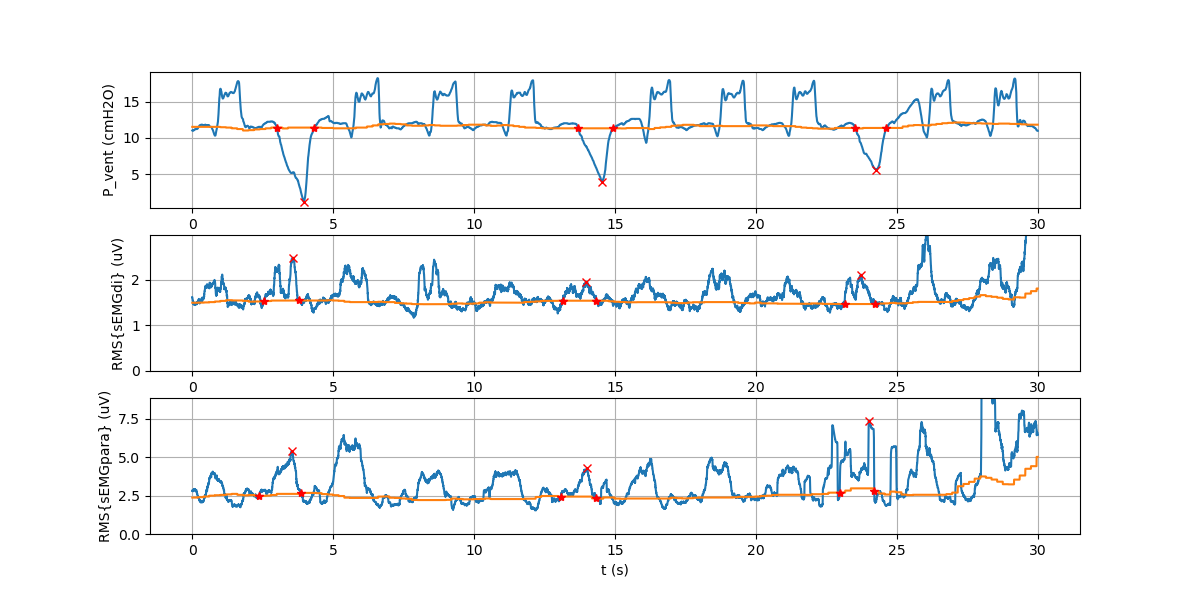

In [2486]:
# Plot entire selected time window with indicated peaks

fig_1, axis = plt.subplots(nrows=3, ncols=1, figsize=(12, 6))
axis[0].grid(True)
axis[0].plot([y / draeger_sample_rate for y in range(len(x))], x)
axis[0].plot([y / draeger_sample_rate for y in range(len(x))],
             P_rolling_base_line)
axis[0].plot(P_occ_peaks/draeger_sample_rate, x[P_occ_peaks], "x", color="r")
axis[0].plot(P_occ_starts / draeger_sample_rate,
             P_rolling_base_line[P_occ_starts], '*r')
axis[0].plot(P_occ_ends / draeger_sample_rate,
             P_rolling_base_line[P_occ_ends], '*r')
axis[0].set_ylabel('P_vent (cmH2O)')

# Rolling baseline:
axis[1].grid(True)
N_samp = len(RMS_data_emg_di[int(start_s):int(end_s)])
axis[1].plot([y / emg_sample_rate for y in range(N_samp)],
             RMS_data_emg_di[int(start_s):int(end_s)])
axis[1].plot([y / emg_sample_rate for y in range(N_samp)],
             emg_di_rolling_base_line[:int(end_s)-int(start_s)])
axis[1].plot(EMG_di_occ_peaks/emg_sample_rate,
             y_di[EMG_di_occ_peaks], "x", color="r")
axis[1].plot(EMG_di_occ_starts / emg_sample_rate,
             emg_di_rolling_base_line[EMG_di_occ_starts], '*r')
axis[1].plot(EMG_di_occ_ends / emg_sample_rate,
             emg_di_rolling_base_line[EMG_di_occ_ends], '*r')
axis[1].set_ylabel('RMS{sEMGdi} (uV)')
axis[1].set_xlabel('t (s)')
axis[1].set_ylim([0, 1.2*max(y_di[EMG_di_occ_peaks])])


axis[2].grid(True)
axis[2].plot([y / emg_sample_rate for y in range(N_samp)],
             RMS_data_emg_para[int(start_s):int(end_s)])
axis[2].plot(EMG_para_occ_peaks/emg_sample_rate,
             y_para[EMG_para_occ_peaks], "x", color="r")

# Rolling baseline:
axis[2].plot([y / emg_sample_rate for y in range(N_samp)],
             emg_para_rolling_base_line[:int(end_s)-int(start_s)])
axis[2].plot(EMG_para_occ_starts / emg_sample_rate,
             emg_para_rolling_base_line[EMG_para_occ_starts], '*r')
axis[2].plot(EMG_para_occ_ends / emg_sample_rate,
             emg_para_rolling_base_line[EMG_para_occ_ends], '*r')
axis[2].set_ylabel('RMS{sEMGpara} (uV)')
axis[2].set_xlabel('t (s)')
axis[2].set_ylim([0, 1.2*max(y_para[EMG_para_occ_peaks])])

(array([6.79519171, 4.4118136 , 3.61430684]),
 array([0.439471  , 0.24321635, 0.35678052]),
 array([1.65822311, 0.8133798 , 2.32873949]),
 array([15.46220735, 18.13946119, 10.13033681]),
 array([1.60705654, 1.27233429, 1.43796258]),
 array([2.05742516, 1.75850833, 2.65498806]))

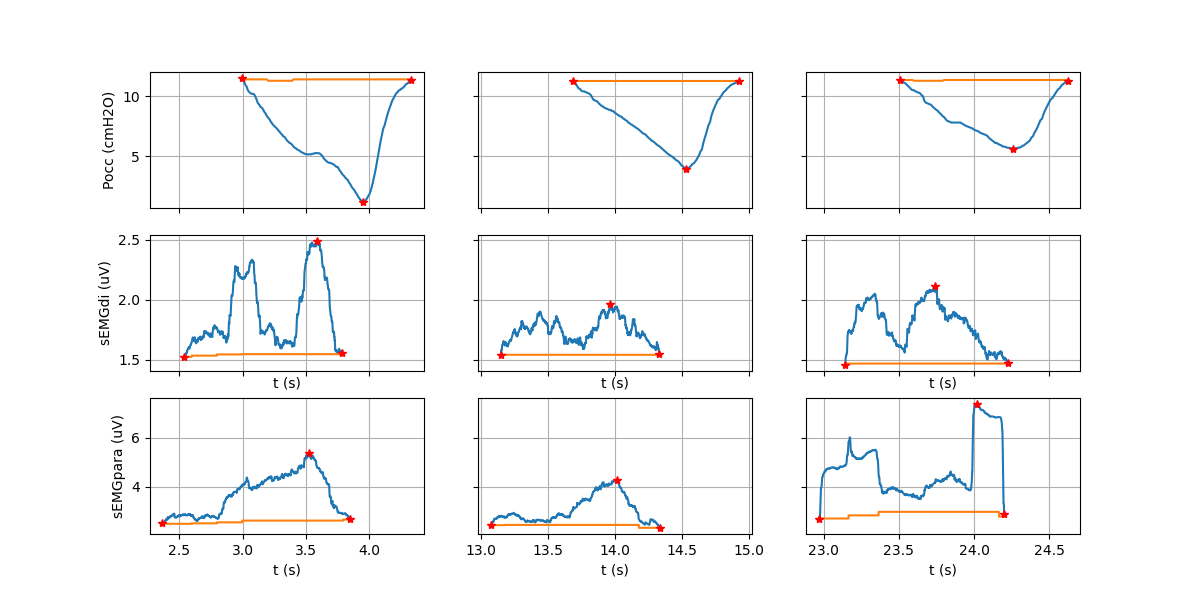

In [2487]:
# Subplot per indicated peak
fig_2, axis = plt.subplots(nrows=3, ncols=len(
    P_occ_peaks), figsize=(12, 6), sharex='col', sharey='row')


PTP_occs = np.zeros((len(P_occ_peaks),))
for idx in range(len(P_occ_peaks)):
    start_i = P_occ_starts[idx]
    end_i = P_occ_ends[idx]
    axis[0, idx].grid(True)
    axis[0, idx].plot(y_draeger[start_i:end_i+1], x[start_i:end_i+1])
    axis[0, idx].plot(y_draeger[start_i:end_i+1],
                      P_rolling_base_line[start_i:end_i+1])

    axis[0, idx].plot(y_draeger[P_occ_peaks[idx]], x[P_occ_peaks[idx]], '*r')
    axis[0, idx].plot(y_draeger[start_i], x[start_i], '*r')
    axis[0, idx].plot(y_draeger[end_i], x[end_i], '*r')

    # Pressure Time Product (ETP) occlusion
    PTP_occs[idx] = np.abs(np.trapz(
        x[start_i:end_i+1]-P_rolling_base_line[start_i:end_i+1],
        dx=1/draeger_sample_rate
    ))

axis[0, 0].set_ylabel('Pocc (cmH2O)')

ETP_di_occs = np.zeros((len(EMG_di_occ_peaks),))
for idx in range(len(EMG_di_occ_peaks)):
    start_i = EMG_di_occ_starts[idx]
    end_i = EMG_di_occ_ends[idx]

    axis[1, idx].grid(True)
    axis[1, idx].plot(y_emg[start_i:end_i+1], y_di[start_i:end_i+1])
    axis[1, idx].plot(y_emg[start_i:end_i+1],
                      emg_di_rolling_base_line[start_i:end_i+1])
    axis[1, idx].plot(y_emg[EMG_di_occ_peaks[idx]],
                      y_di[EMG_di_occ_peaks[idx]], '*r')
    axis[1, idx].plot(y_emg[start_i], y_di[start_i], '*r')
    axis[1, idx].plot(y_emg[end_i], y_di[end_i], '*r')

    # EMG Time Product (ETP) diaphragm
    ETP_di_occs[idx] = np.trapz(
        y_di[start_i:end_i+1] - emg_di_rolling_base_line[start_i:end_i+1],
        dx=1/emg_sample_rate
    )

    axis[1, idx].set_xlabel('t (s)')

axis[1, 0].set_ylabel('sEMGdi (uV)')

ETP_para_occs = np.zeros((len(EMG_para_occ_peaks),))
for idx in range(len(EMG_para_occ_peaks)):
    start_i = EMG_para_occ_starts[idx]
    end_i = EMG_para_occ_ends[idx]

    axis[2, idx].grid(True)
    axis[2, idx].plot(y_emg[start_i:end_i+1], y_para[start_i:end_i+1])
    axis[2, idx].plot(y_emg[start_i:end_i+1],
                      emg_para_rolling_base_line[start_i:end_i+1])
    axis[2, idx].plot(y_emg[EMG_para_occ_peaks[idx]],
                      y_para[EMG_para_occ_peaks[idx]], '*r')
    axis[2, idx].plot(y_emg[start_i], y_para[start_i], '*r')
    axis[2, idx].plot(y_emg[end_i], y_para[end_i], '*r')

    # EMG Time Product (ETP) parasternal
    ETP_para_occs[idx] = np.trapz(
        y_para[start_i:end_i+1] - emg_para_rolling_base_line[start_i:end_i+1],
        dx=1/emg_sample_rate
    )

    axis[2, idx].set_xlabel('t (s)')

axis[2, 0].set_ylabel('sEMGpara (uV)')


# Calculated neuromuscular efficiency: NME = PTP / ETP_di
NME_di = np.abs(PTP_occs)/ETP_di_occs

SNR_di = hf.snr_pseudo(
    src_signal=RMS_data_emg_di[int(start_s):int(end_s)], 
    peaks=EMG_di_occ_peaks, 
    baseline=emg_di_rolling_base_line[:int(end_s)-int(start_s)]\
)
SNR_para = hf.snr_pseudo(
    src_signal=RMS_data_emg_para[int(start_s):int(end_s)], 
    peaks=EMG_para_occ_peaks, 
    baseline=emg_para_rolling_base_line[:int(end_s)-int(start_s)]    
)


PTP_occs, ETP_di_occs, ETP_para_occs, NME_di, SNR_di, SNR_para

# Store values for later analysis

In [2488]:
# fig_1.savefig(main_output_dir + '/' + patient + '/' + measurements[date_idx] + '/' + measurements[date_idx] + '_' + patient + '_' + 
#               measurement + '_timeplots_'+str(int(gate_width*1000))+'.png', dpi=300)
# fig_2.savefig(main_output_dir + '/' + patient + '/' + measurements[date_idx]  + '/' + measurements[date_idx] + '_' + patient + '_' + 
#               measurement + '_snapshots_'+str(int(gate_width*1000))+'.png', dpi=300)

for idx in range(len(PTP_occs)):
    data_now = [patient, measurement, PEEP_set, PTP_occs[idx],
                ETP_di_occs[idx], NME_di[idx], ETP_para_occs[idx], SNR_di[idx], SNR_para[idx]]
    big_data_list.append(data_now)

patient, measurement

('MST015', '009')

In [2489]:
# del big_data_list[:]

# big_data_list = list(df.values)

big_data_list

[['MST015',
  '006',
  5.0,
  4.2843110108934335,
  0.11851272180398496,
  36.15064227433324,
  0.13093675941107535,
  1.2856218715366567,
  1.1366666587858605],
 ['MST015',
  '006',
  5.0,
  5.792179529331625,
  0.07444313248578853,
  77.8067678766389,
  2.2424737171152245,
  1.2321823776630398,
  1.7409577597381294],
 ['MST015',
  '006',
  5.0,
  4.214802001528441,
  1.5349111412398333,
  2.7459583087812565,
  4.096573941298686,
  1.852916713117547,
  2.1308035099827274],
 ['MST015',
  '007',
  7.0,
  3.3939025623351338,
  0.1980329971859096,
  17.138065931249844,
  0.3158327294878882,
  1.3816532416487601,
  1.2462733986577894],
 ['MST015',
  '007',
  7.0,
  5.228048099502923,
  0.2729779385743574,
  19.15190702518561,
  4.286104779569381,
  1.6358575825463009,
  1.9160425770492766],
 ['MST015',
  '007',
  7.0,
  6.332595022730529,
  0.21995308726943325,
  28.790662142302043,
  0.5573954041558373,
  1.3340393006671654,
  1.2892276865504162],
 ['MST015',
  '008',
  9.0,
  5.673646699

In [2490]:
columns_now = ['patient', 'measurement', 'PEEP_set', 'PTP_occs', 'ETP_di_occs', 'NME_di', 'ETP_para_occs', 'SNR_di', 'SNR_para'
               ]
df = pd.DataFrame(big_data_list, columns=columns_now)
df

,patient,measurement,PEEP_set,PTP_occs,ETP_di_occs,NME_di,ETP_para_occs,SNR_di,SNR_para
0,MST015,006,5.0,4.284311,0.118513,36.150642,0.130937,1.285622,1.136667
1,MST015,006,5.0,5.792180,0.074443,77.806768,2.242474,1.232182,1.740958
2,MST015,006,5.0,4.214802,1.534911,2.745958,4.096574,1.852917,2.130804
3,MST015,007,7.0,3.393903,0.198033,17.138066,0.315833,1.381653,1.246273
4,MST015,007,7.0,5.228048,0.272978,19.151907,4.286105,1.635858,1.916043
5,MST015,007,7.0,6.332595,0.219953,28.790662,0.557395,1.334039,1.289228
6,MST015,008,9.0,5.673647,0.349828,16.218404,3.116706,1.629986,1.491822
7,MST015,008,9.0,3.645899,0.440562,8.275570,0.850758,1.410239,1.356860
8,MST015,008,9.0,6.238351,0.070353,88.671623,1.699590,1.258585,1.910975
9,MST015,009,11.0,6.795192,0.439471,15.462207,1.658223,1.607057,2.057425


Text(0.5, 1.0, '')

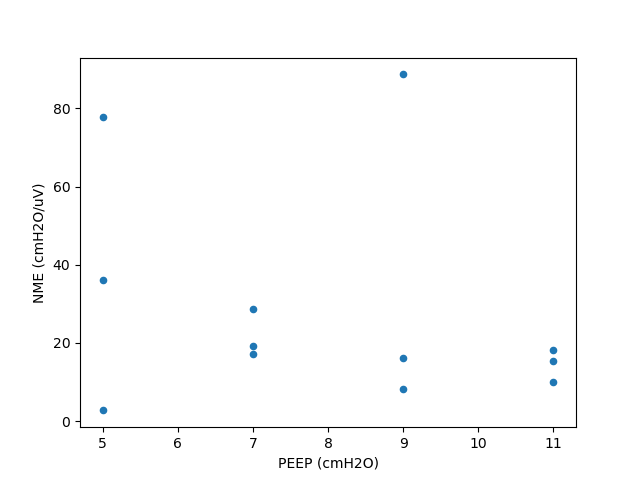

In [2491]:
bp = df.plot.scatter('PEEP_set', 'NME_di')
bp.set_ylabel('NME (cmH2O/uV)')
bp.set_xlabel('PEEP (cmH2O)')
bp.set_title('')

In [2492]:
if gate_twice == True:
    N_gated = 2
else:
    N_gated = 1

context = patient + ' / ' + measurements[date_idx] + ' / ' + measurement + '\n' + \
't_start: ' + str(start) + ' s' + '\n' + \
't_end: ' + str(end) + ' s' + '\n' + \
'gate_width: ' + str(int(gate_width*1000)) + ' ms' + '\n' + \
'gate_threshold: ' + str(peak_fraction) + '' + '\n' + \
'gate_ECG_shift: ' + str(ECG_shift) + ' samples' + '\n' + \
'time_shift: ' + str(draeger_delay) + ' s' + '\n' + \
'Pocc_prominence_factor: ' + str(Pocc_prominence_factor) + '' + '\n' + \
'EMG_di_prominence_factor: ' + str(EMG_di_prominence_factor) + '' + '\n' + \
'EMG_para_prominence_factor: ' + str(EMG_para_prominence_factor) + '' + '\n' + \
'PEEP_set: ' + str(PEEP_set) + '' + '\n' + \
'N_gated: ' + str(N_gated) + '' + '\n' + \
'analysis_date: ' + str(datetime.now())

with open(main_output_dir + '/' + patient + '/' + measurements[date_idx] + '/' + measurements[date_idx] + '_' + patient + '_' + measurement + '_readme.txt', 'w') as f:
    f.write(context)

print(context)

MST015 / 2022-10-28_14-36-23 / 009
t_start: 295.0 s
t_end: 325.0 s
gate_width: 100 ms
gate_threshold: 0.3
gate_ECG_shift: -10 samples
time_shift: 0.5 s
Pocc_prominence_factor: 0.5
EMG_di_prominence_factor: 0.05
EMG_para_prominence_factor: 0.01
PEEP_set: 11.0
N_gated: 1
analysis_date: 2023-04-26 15:41:41.814484


In [2493]:
# Move on to the next measurement
measurement_idx += 1

['To next PEEP step'](#section_peep_step)

## Next date: Store session data

In [2494]:
# Store session data if complete
if len(set(df['PEEP_set'].values)) < 4:
    print('Warning: Not 4 PEEP settings evaluated yet!')
else:
    
    # df.to_csv(main_output_dir + '/' + patient + '/' + measurements[date_idx]  + '/' + measurements[date_idx] + '_' + patient +
    #         '_NME_output_gate_'+str(int(gate_width*1000))+'.csv')
    # # bp.figure.savefig(main_output_dir + patient + '/' + patient + '_'+str(int(gate_width*1000))+'_boxplot.png', dpi=300)
    # bp.figure.savefig(main_output_dir + '/' + patient + '/' + measurements[date_idx]  + '/' + measurements[date_idx] + '_' + patient +
    #                 '_gate_'+str(int(gate_width*1000))+'_scatter.png', dpi=300)

    columns_ecg = ['patient', 'measurement', 'PEEP_set', 'ecg_rms'
                   ]
    ecg_data_list.append(ecg_data_list_new)
    df_ecg = pd.DataFrame(ecg_data_list, columns=columns_ecg)
    
    print('Notification: Data of 4 PEEP settings stored!')

Notification: Data of 4 PEEP settings stored!


In [2495]:
# Move on to the next measurement date if data saved

if not os.path.exists(main_output_dir + '/' + patient + '/' + measurements[date_idx]  + '/' + measurements[date_idx] + '_' + patient +
          '_NME_output_gate_'+str(int(gate_width*1000))+'.csv'):
    print('Warning: Data not stored! Do not progress to next date!')
else:
    print('Notification: Data appropriately stored. You may progress to next date!')
    date_idx += 1

Notification: Data appropriately stored. You may progress to next date!


In [2496]:
# # Save data anyway:
# df.to_csv(main_output_dir + '/' + patient + '/' + measurements[date_idx]  + '/' + measurements[date_idx] + '_' + patient +
#             '_NME_output_gate_'+str(int(gate_width*1000))+'.csv')

# bp.figure.savefig(main_output_dir + '/' + patient + '/' + measurements[date_idx]  + '/' + measurements[date_idx] + '_' + patient +
#                 '_gate_'+str(int(gate_width*1000))+'_scatter.png', dpi=300)

In [2455]:
# # Move on to the next measurement date
# date_idx += 1

In [2456]:
# # Move on to the previous measurement date
# date_idx -= 1

['To next measurement date'](#section_date_step)

In [2457]:
# Move on to the next patient
patient_idx += 1

In [2460]:
# # Move on to the previous patient
# patient_idx -= 1

['To next patient'](#section_patient_step)

In [2459]:
# gate_twice = True